In [1]:
import parselmouth
import webrtcvad
import librosa
import numpy as np
import pandas as pd
import seaborn as sns
import soundfile as sf

import os
import warnings
warnings.filterwarnings('ignore')

from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile

%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display

In [21]:
path = '../DataCampus_project/'

In [22]:
os.listdir(path+'Audio')

['.ipynb_checkpoints',
 'blackpink.wav',
 'Default_hello1.wav',
 'Default_hello2.wav']

In [23]:
file1 = path+'Audio/Default_hello1.wav'
file2 = path+'Audio/Default_hello2.wav'

In [24]:
import IPython.display as ipd
ipd.Audio(file1)

In [25]:
import IPython.display as ipd
ipd.Audio(file2)

### "hello 1"

Sample Rate:  16000
DATA       :  <class 'numpy.ndarray'> (67920,) [-9.4217721e-06  8.5613574e-06 -7.0489887e-06 ...  1.3023949e-03
  1.9765892e-03  0.0000000e+00]
original_file_duration:4.245 sec


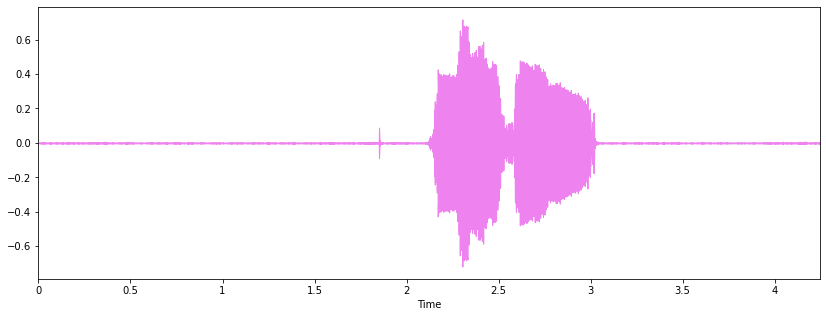

In [162]:
sample1, sample_rate1 = librosa.load(file1, mono=True, sr=16000)## librosa로 load할 수 있다.

print("Sample Rate: ", sample_rate1)
print("DATA       : ", type(sample1), sample1.shape, sample1) ## sequences는 정규화가 되어서 나온다.
dur = len(sample1)/sample_rate1
print(f"original_file_duration:{dur} sec")

plt.figure(figsize=(14, 5))
librosa.display.waveplot(sample1, sr=sample_rate1, color='violet')

### "hello 2"

Sample Rate:  16000
DATA       :  <class 'numpy.ndarray'> (68603,) [-1.1094717e-05  1.0466113e-05 -9.1419324e-06 ... -2.4479232e-03
 -2.5633073e-03  0.0000000e+00]
original_file_duration:4.2876875 sec


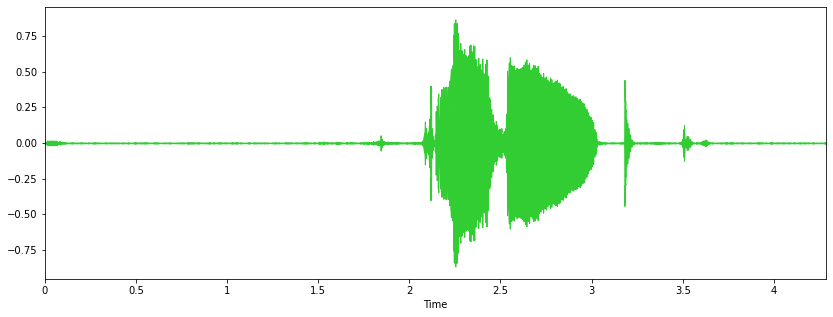

In [163]:
sample2, sample_rate2 = librosa.load(file2, mono=True, sr=16000)## librosa로 load할 수 있다.

print("Sample Rate: ", sample_rate2)
print("DATA       : ", type(sample2), sample2.shape, sample2) ## sequences는 정규화가 되어서 나온다.
dur = len(sample2)/sample_rate2
print(f"original_file_duration:{dur} sec")

plt.figure(figsize=(14, 5))
librosa.display.waveplot(sample2, sr=sample_rate2, color='limegreen')

## VAD

In [44]:
import struct

sr1, y1 =wavfile.read(file1)
sr2, y2 =wavfile.read(file2)

y1 = y1[:,0]
y2 = y2[:,0]

In [143]:
def vad(samples, sample_rate=16000):
    vad=webrtcvad.Vad()
    vad.set_mode(3)

    raw_samples = struct.pack("%dh" % len(samples), *samples)
    
    window_duration = 0.01 # duration in seconds
    samples_per_window = int(window_duration * sample_rate + 0.5)
    bytes_per_sample = 2
    
    segments = []

    for i,start in enumerate(np.arange(0, len(samples), samples_per_window)):
        stop = min(start + samples_per_window, len(samples))

        if stop == len(samples):
            break

        is_speech = vad.is_speech(raw_samples[start * bytes_per_sample: stop * bytes_per_sample], sample_rate = sample_rate) 
        segments.append({'start':start, 'stop':stop, 'is_speech':is_speech})
               
    speech_samples = np.concatenate([ samples[segment['start']:segment['stop']] for segment in segments if segment['is_speech']])
    
    
    start=[]
    end=[]
    for segment in segments:
        if segment['is_speech']:
            if samples[segment['start']]>3000:
                start.append(segment['start'])
                end.append(segment['stop'])

    print(f"start:{np.round(np.min(start)/22050, 2)} sec, stop:{np.round(np.max(end)/22050, 2)} sec")
    
    return speech_samples

In [176]:
def vad_plot(samples):
    vad=webrtcvad.Vad()
    vad.set_mode(3)

    raw_samples = struct.pack("%dh" % len(samples), *samples)
    
    window_duration = 0.01 # duration in seconds
    samples_per_window = int(window_duration * sample_rate1 + 0.5)
    bytes_per_sample = 2
    
    segments = []

    for i,start in enumerate(np.arange(0, len(samples), samples_per_window)):
        stop = min(start + samples_per_window, len(samples))

        if stop == len(samples):
            break

        is_speech = vad.is_speech(raw_samples[start * bytes_per_sample: stop * bytes_per_sample], sample_rate = sample_rate1)
        segments.append({'start':start, 'stop':stop, 'is_speech':is_speech})
        
    plt.figure(figsize = (14,5))
    plt.plot(samples, color = 'lightcoral')

    ymax = max(samples)


    # plot segment identifed as speech
    for segment in segments:
        if segment['is_speech']:
            plt.plot([ segment['start'], segment['stop'] - 1], [ymax * 1.1, ymax * 1.1], color = 'cornflowerblue')

    plt.xlabel('sample')
    plt.grid()


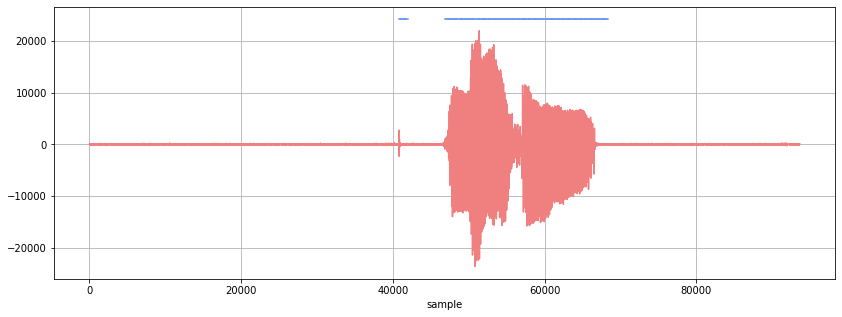

In [177]:
vad_plot(y1)

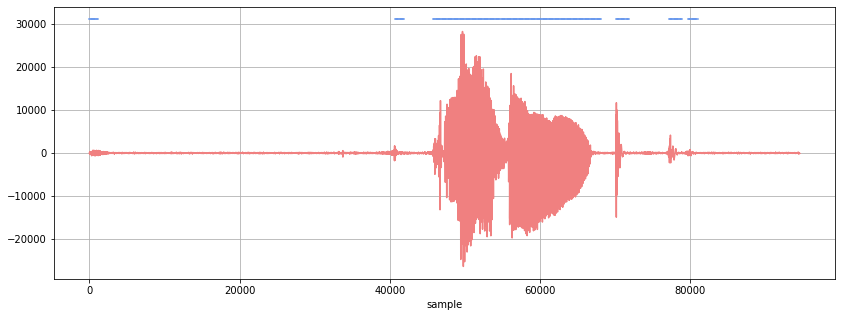

In [178]:
vad_plot(y2)

In [144]:
cut_1 = vad(y1)
cut_2 = vad(y2)

start:2.16 sec, stop:2.93 sec
start:2.12 sec, stop:3.0 sec


In [110]:
len(cut_1), len(cut_2)

(22560, 29600)

In [111]:
ipd.Audio(cut_1 ,rate=sr1)

In [112]:
ipd.Audio(cut_2, rate=sr2)

## Parselmouth

####  webrtcvad를 통해서 소리가 있는 부분의 start, end time 찾아내기

In [303]:
def cut_time(samples, sample_rate=16000):
    vad=webrtcvad.Vad()
    vad.set_mode(3)

    raw_samples = struct.pack("%dh" % len(samples), *samples)
    
    window_duration = 0.01 # duration in seconds
    samples_per_window = int(window_duration * sample_rate + 0.5)
    bytes_per_sample = 2
    
    segments = []

    for i,start in enumerate(np.arange(0, len(samples), samples_per_window)):
        stop = min(start + samples_per_window, len(samples))

        if stop == len(samples):
            break

        is_speech = vad.is_speech(raw_samples[start * bytes_per_sample: stop * bytes_per_sample], sample_rate = sample_rate) 
        segments.append({'start':start, 'stop':stop, 'is_speech':is_speech})
               
    speech_samples = np.concatenate([ samples[segment['start']:segment['stop']] for segment in segments if segment['is_speech']])
    
    
    start=[]
    end=[]
    for segment in segments:
        if segment['is_speech']:
            if samples[segment['start']]>5000:
                start.append(segment['start'])
                end.append(segment['stop'])

    #print(f"start:{np.round(np.min(start)/22050, 2)} sec, stop:{np.round(np.max(end)/22050, 2)} sec")
    
    s = np.float(np.round(np.min(start)/22050, 2))
    e = np.float(np.round(np.max(end)/22050, 2))
    
    return s,e

#### 시각화할 plot들 정의

In [286]:
def draw_spectrogram(spectrogram, dynamic_range=70):
    X, Y = spectrogram.x_grid(), spectrogram.y_grid()
    sg_db = 10 * np.log10(spectrogram.values)
    plt.pcolormesh(X, Y, sg_db, vmin=sg_db.max() - dynamic_range, cmap='afmhot')
    plt.ylim([spectrogram.ymin, spectrogram.ymax])
    plt.xlabel("time [s]")
    plt.ylabel("frequency [Hz]")

def draw_intensity(intensity):
    plt.plot(intensity.xs(), intensity.values.T, linewidth=3, color='w')
    plt.plot(intensity.xs(), intensity.values.T, linewidth=1)
    plt.grid(False)
    plt.ylim(0)
    plt.ylabel("intensity [dB]")

def draw_pitch(pitch):
    # Extract selected pitch contour, and
    # replace unvoiced samples by NaN to not plot
    pitch_values = pitch.selected_array['frequency']
    pitch_values[pitch_values==0] = np.nan
    plt.plot(pitch.xs(), pitch_values, 'o', markersize=5, color='w')
    plt.plot(pitch.xs(), pitch_values, 'o', markersize=2)
    plt.grid(False)
    plt.ylim(0, pitch.ceiling)
    plt.ylabel("fundamental frequency [Hz]")
    
intensity1 = snd_part1.to_intensity()
intensity2 = snd_part2.to_intensity()

spectrogram1 = snd_part1.to_spectrogram()
spectrogram2 = snd_part2.to_spectrogram()

pitch1 = snd_part1.to_pitch()
pitch2 = snd_part2.to_pitch()

#### 소리가 있는 부분의 plot들 비교해보기(amplitude, intensity, spectrogram, pitch)

In [287]:
def cut_plot(file1, file2):
    sr1, y1 =wavfile.read(file1)
    sr2, y2 =wavfile.read(file2)

    y1 = y1[:,0]
    y2 = y2[:,0]
    
    s1,e1 = cut_time(y1)
    s2,e2 = cut_time(y2)
    
    snd1 = parselmouth.Sound(file1)
    snd2 = parselmouth.Sound(file2)
    
    snd_part1 = snd1.extract_part(from_time = s1, to_time = e1) ## VAD
    snd_part2 = snd2.extract_part(from_time = s2, to_time = e2)
    
    plt.figure(figsize=(14,5))
    plt.plot(snd_part1.xs(), snd_part1.values.T, linewidth=0.5, color='violet')
    plt.xlim([snd_part1.xmin, snd_part1.xmax])
    plt.xlabel("time [s]")
    plt.ylabel("amplitude")
    plt.show()

    plt.figure(figsize=(14,5))
    plt.plot(snd_part2.xs(), snd_part2.values.T, linewidth=0.5, color='limegreen')
    plt.xlim([snd_part2.xmin, snd_part2.xmax])
    plt.xlabel("time [s]")
    plt.ylabel("amplitude")
    plt.show()
    
    plt.figure(figsize=(14,5))
    draw_spectrogram(spectrogram1)
    plt.twinx()
    draw_intensity(intensity1)
    plt.xlim([snd_part1.xmin, snd_part1.xmax])
    plt.title('hello1 spectrogram&intensity')
    plt.show()


    plt.figure(figsize=(14,5))
    draw_spectrogram(spectrogram2)
    plt.twinx()
    draw_intensity(intensity2)
    plt.xlim([snd_part2.xmin, snd_part2.xmax])
    plt.title('hello2 spectrogram&intensity')
    plt.show()
    
    plt.figure(figsize=(14,5))
    draw_spectrogram(spectrogram1)
    plt.twinx()
    draw_pitch(pitch1)
    plt.title("hello1 spectrogram & pitch")


    plt.figure(figsize=(14,5))
    draw_spectrogram(spectrogram2)
    plt.twinx()
    draw_pitch(pitch2)
    plt.title("hello2 spectrogram & pitch")


start:2.24 sec, stop:2.93 sec
start:2.12 sec, stop:2.87 sec


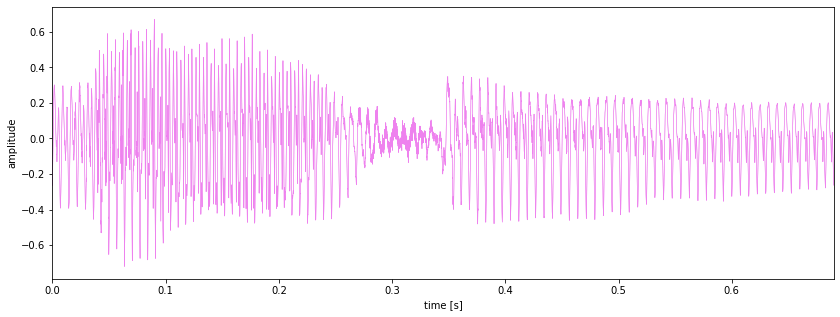

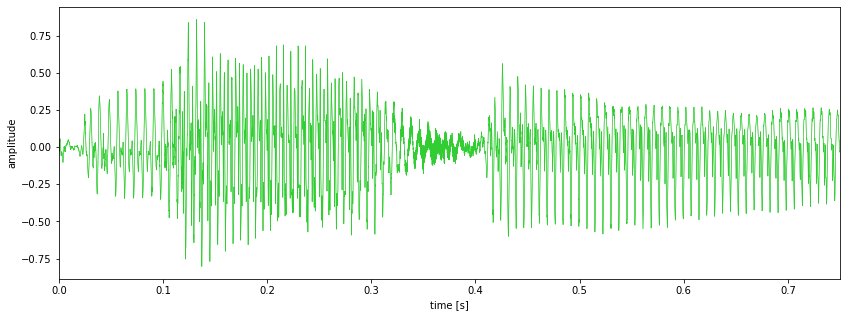

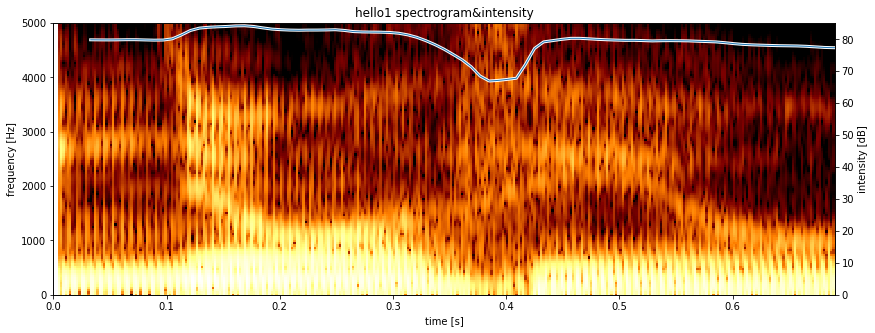

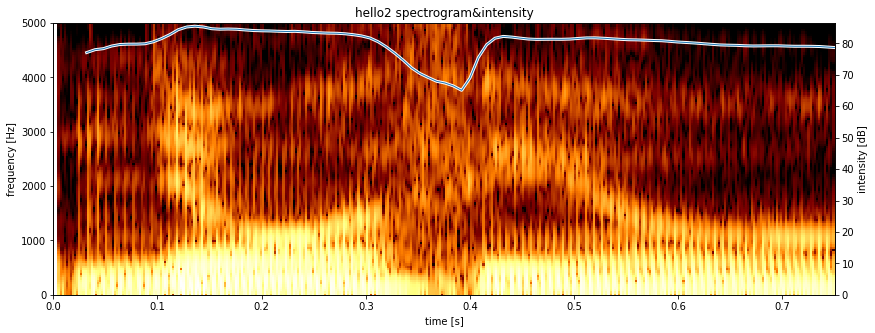

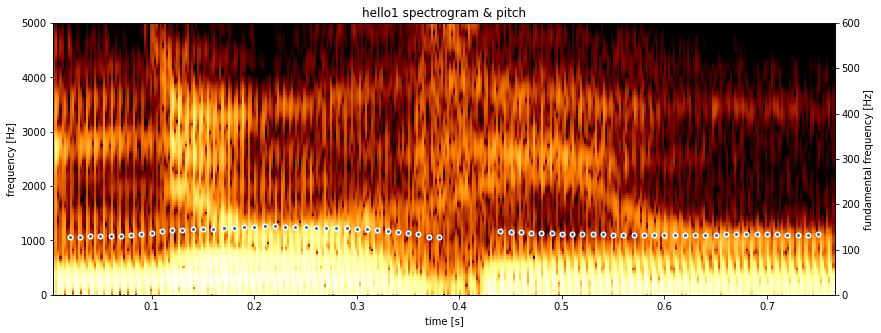

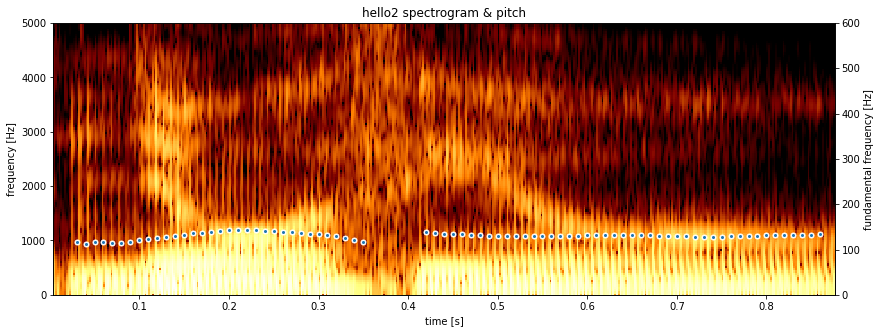

In [288]:
cut_plot(file1, file2)

####  오디오들의 sec, pitch, intensity값들을 Dataframe으로 시각화

In [304]:
def show_df(file1, file2):
    sr1, y1 =wavfile.read(file1)
    sr2, y2 =wavfile.read(file2)

    y1 = y1[:,0]
    y2 = y2[:,0]
    
    s1,e1 = cut_time(y1)
    s2,e2 = cut_time(y2)
    
    snd1 = parselmouth.Sound(file1)
    snd2 = parselmouth.Sound(file2)
    
    snd_part1 = snd1.extract_part(from_time = s1, to_time = e1) ## VAD
    snd_part2 = snd2.extract_part(from_time = s2, to_time = e2)
    
    intensity1 = snd_part1.to_intensity()
    intensity2 = snd_part2.to_intensity()

    spectrogram1 = snd_part1.to_spectrogram()
    spectrogram2 = snd_part2.to_spectrogram()

    pitch1 = snd_part1.to_pitch()
    pitch2 = snd_part2.to_pitch()
    
    z1 = e1-s1
    z2 = e2-s2
    
    if z1> z2:
        intensity_sep = np.float(round((e1-s1)/intensity1.values.shape[1], 5))
        pitch_sep = np.float(round((e1-s1)/pitch1.selected_array['frequency'].shape[0], 5))

        intensity_sec = np.arange(s1,e1, intensity_sep)[:-1]
        pitch_sec = np.arange(s1,e1, pitch_sep )[:-1]

    else:
        intensity_sep = np.float(round((e2-s2)/intensity1.values.shape[1], 5))
        pitch_sep = np.float(round((e2-s2)/pitch1.selected_array['frequency'].shape[0], 5))

        intensity_sec = np.arange(s2,e2, intensity_sep)[:-1]
        pitch_sec = np.arange(s2,e2, pitch_sep )[:-1]

    
    dict1 = {'sec': intensity_sec,
            'intensity1': intensity1.values.reshape(-1,),
             'intensity2': intensity2.values.reshape(-1,)
            }

    dict2 = {
             'sec': pitch_sec,
             'pitch1': pitch1.selected_array['frequency'],
             'pitch2': pitch2.selected_array['frequency']
            }  

    df1 = pd.DataFrame.from_dict(dict1, orient='index').transpose()
    df2 = pd.DataFrame.from_dict(dict2, orient='index').transpose()  

    df1.fillna(method='pad', inplace=True)
    df2.fillna(method='pad', inplace=True)
    
    return df1, df2

    

In [305]:
df1, df2 = show_df(file1, file2)

In [306]:
df1

,sec,intensity1,intensity2
0,2.12000,81.361436,77.626844
1,2.12949,82.774413,78.083246
2,2.13898,83.525466,78.627435
3,2.14847,83.788054,79.425799
4,2.15796,83.930930,79.729853
...,...,...,...
81,2.86022,76.987557,79.243863
82,2.86022,76.987557,79.270395
83,2.86022,76.987557,79.229282
84,2.86022,76.987557,79.121553


In [307]:
df2

,sec,pitch1,pitch2
0,2.12000,135.916258,0.000000
1,2.13136,140.970765,116.806083
2,2.14272,142.432538,111.147154
3,2.15408,142.906847,116.325804
4,2.16544,144.165335,116.735577
...,...,...,...
67,2.85840,133.183331,129.443459
68,2.85840,133.183331,129.052334
69,2.85840,133.183331,128.816548
70,2.85840,133.183331,128.310885


#### 각각의 pitch, intensity값들을 비교하여 차이가 심한 부분들을 error part로 가정하고 해당하는 부분들 slicing

In [353]:
def show_error_part(file1, file2):
    sr = 22050
    
    df1, df2 = show_df(file1, file2)
    
    intensity_sub = []
    pitch_sub = []

    for a,b in df1.iloc[:,1:].values:
        intensity_sub.append(np.abs(a-b))

    for a,b in df2.iloc[:,1:].values:
        pitch_sub.append(np.abs(a-b))
        
    ## error는 두 값들의 차이를 displot을 통해 판단하기  
    plt.figure(figsize=(6,6))
    sns.distplot(intensity_sub)
    plt.title('intensity_error_density')
    
    plt.figure(figsize=(6,6))
    sns.distplot(pitch_sub)
    plt.title('pitch_error_density')
        
    intensity_error_idx=[i for i,k in enumerate(intensity_sub) if k>12] 
    pitch_error_idx=[i for i,k in enumerate(pitch_sub) if k>100]
    
    intensity_error_sec = df1.sec.loc[intensity_error_idx].values
    pitch_error_sec = df2.sec.loc[pitch_error_idx].values
    
    intensity_error_part = y2[round(np.min(intensity_error_sec)*sr1):round(np.max(intensity_error_sec)*sr1)]
    pitch_error_part = y2[round(np.min(pitch_error_sec)*sr1):round(np.max(pitch_error_sec)*sr1)]
    
    
    #print(f"intensity_error_sec:{intensity_error_sec}")
    #print(f"pitch_error_sec:{pitch_error_sec}")
    
    print(f'intensity_error_part:{intensity_error_part}')
    print(f'pitch_error_part:{pitch_error_part}')
    
    
    return intensity_error_part, pitch_error_part
       

intensity_error_part:[8487 9398 9809 ... 6288 6096 5841]
pitch_error_part:[1416  923  425 ... 3484 2779 2768]


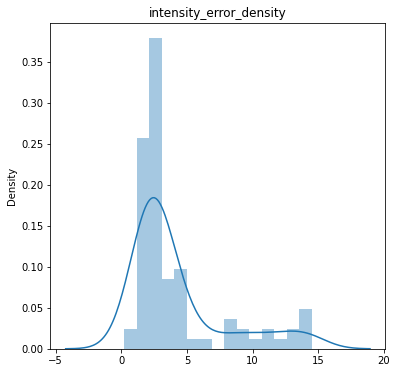

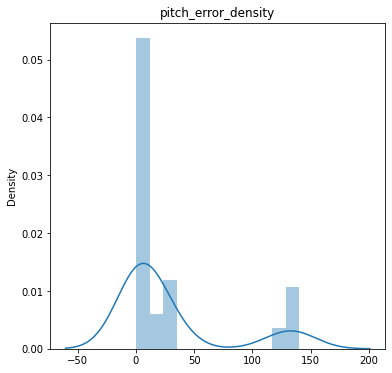

In [354]:
intensity_error_part, pitch_error_part = show_error_part(file1, file2)

### intensity_error가 있는 part(hello2) 들어보기

In [344]:
ipd.Audio(intensity_error_part, rate=sr2)

### pitch_error가있는 part(hello2) 들어보기

In [355]:
ipd.Audio(pitch_error_part, rate=sr2)